# **Transfer Value Prediction**

**Objective: This is important to assess the value of a player so that clubs can balance their budgets and build a competitive squad, while getting max return on investment and identifying undervalued talents.**

**Submission by: Team Data Dynamo (Puyush, Prayas Mazumder, Kushal Asish Chidithoti)**

In [182]:
!pip install pyspark 

In [183]:
import pyspark 
import numpy as pd
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, when, mean, sum as spark_sum, format_number, concat
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

spark = SparkSession.builder.appName("project").getOrCreate()

df = spark.read.option('header', 'True').csv("train.csv", inferSchema = True, header = True)
df.show()

+----+------------------+----------------+---+-------+-------------------------+----------------+------+----------+-----------+---------------------------+-------------+---------------+------------------------+------------------------------+----------------------+------------------+-------------------+-----+-------------------+---------------------------------+-------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+
|  id|              Name|Aerial Duels won|Age|Assists|Attacking options created|Attempted Passes|Blocks|Clearances|    Country|Expected Goal Contributions|Interceptions|Open Play Goals|Open Play Expected Goals|Percentage of Passes Completed|Progressive Passes Rec|Progressive Passes|Progressive Carries|Shots|Successful Dribbles|Touches in attacking penalty area|Tackles|Value at beginning of 2020/21 season|Value at beginning of 2021/22 season|Value at beginning of 2022/23 seaso

In [184]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Aerial Duels won: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Assists: double (nullable = true)
 |-- Attacking options created: double (nullable = true)
 |-- Attempted Passes: double (nullable = true)
 |-- Blocks: double (nullable = true)
 |-- Clearances: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- Expected Goal Contributions: double (nullable = true)
 |-- Interceptions: double (nullable = true)
 |-- Open Play Goals: double (nullable = true)
 |-- Open Play Expected Goals: double (nullable = true)
 |-- Percentage of Passes Completed: double (nullable = true)
 |-- Progressive Passes Rec: double (nullable = true)
 |-- Progressive Passes: double (nullable = true)
 |-- Progressive Carries: double (nullable = true)
 |-- Shots: double (nullable = true)
 |-- Successful Dribbles: double (nullable = true)
 |-- Touches in attacking penalty area: double (nullable = true)


In [185]:
df.dtypes

[('id', 'int'),
 ('Name', 'string'),
 ('Aerial Duels won', 'double'),
 ('Age', 'int'),
 ('Assists', 'double'),
 ('Attacking options created', 'double'),
 ('Attempted Passes', 'double'),
 ('Blocks', 'double'),
 ('Clearances', 'double'),
 ('Country', 'string'),
 ('Expected Goal Contributions', 'double'),
 ('Interceptions', 'double'),
 ('Open Play Goals', 'double'),
 ('Open Play Expected Goals', 'double'),
 ('Percentage of Passes Completed', 'double'),
 ('Progressive Passes Rec', 'double'),
 ('Progressive Passes', 'double'),
 ('Progressive Carries', 'double'),
 ('Shots', 'double'),
 ('Successful Dribbles', 'double'),
 ('Touches in attacking penalty area', 'double'),
 ('Tackles', 'double'),
 ('Value at beginning of 2020/21 season', 'double'),
 ('Value at beginning of 2021/22 season', 'double'),
 ('Value at beginning of 2022/23 season', 'double'),
 ('Value at beginning of 2023/24 season', 'double')]

In [186]:
# Calculate the sum of null values for each column
null_counts = df.select([spark_sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])

# Show the null value counts
null_counts.show()

+---+----+----------------+---+-------+-------------------------+----------------+------+----------+-------+---------------------------+-------------+---------------+------------------------+------------------------------+----------------------+------------------+-------------------+-----+-------------------+---------------------------------+-------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+
| id|Name|Aerial Duels won|Age|Assists|Attacking options created|Attempted Passes|Blocks|Clearances|Country|Expected Goal Contributions|Interceptions|Open Play Goals|Open Play Expected Goals|Percentage of Passes Completed|Progressive Passes Rec|Progressive Passes|Progressive Carries|Shots|Successful Dribbles|Touches in attacking penalty area|Tackles|Value at beginning of 2020/21 season|Value at beginning of 2021/22 season|Value at beginning of 2022/23 season|Value at beginning of 2023/24 season

# **Feature Engineering**

In [187]:
df = df.withColumn(
    "Progressive Passes per Attempted Passes",
    col("Progressive Passes") / col("Attempted Passes")
)

df = df.withColumn("Progressive Passes per Attempted Passes", format_number(col("Progressive Passes per Attempted Passes"), 2))

df.show(3)

+---+----------------+----------------+---+-------+-------------------------+----------------+------+----------+-------+---------------------------+-------------+---------------+------------------------+------------------------------+----------------------+------------------+-------------------+-----+-------------------+---------------------------------+-------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+---------------------------------------+
| id|            Name|Aerial Duels won|Age|Assists|Attacking options created|Attempted Passes|Blocks|Clearances|Country|Expected Goal Contributions|Interceptions|Open Play Goals|Open Play Expected Goals|Percentage of Passes Completed|Progressive Passes Rec|Progressive Passes|Progressive Carries|Shots|Successful Dribbles|Touches in attacking penalty area|Tackles|Value at beginning of 2020/21 season|Value at beginning of 2021/22 season|Value at 

In [188]:
# Count the occurrences of each unique value in the 'Country' column
country_counts = df.groupBy("Country").count()
country_counts = country_counts.orderBy(col("count").desc())

# Show the result
country_counts.show()

+-----------+-----+
|    Country|count|
+-----------+-----+
|      Spain|  156|
|     France|  154|
|    Germany|  100|
|    England|   96|
|      Italy|   95|
|       null|   73|
|     Brazil|   64|
|  Argentina|   41|
|   Portugal|   37|
|Netherlands|   32|
|    Denmark|   25|
|    Belgium|   24|
|    Croatia|   21|
|    Algeria|   19|
|      Ghana|   19|
|    Nigeria|   18|
|    Austria|   18|
|    Morocco|   17|
|    Senegal|   17|
|    Uruguay|   17|
+-----------+-----+
only showing top 20 rows



In [189]:
# Identify countries with count less than or equal to 14 and replace with 'Other'
countries_to_replace = list(country_counts.filter(col("count") <= 14).select("Country").toPandas()['Country'])

# Replace missing values in the 'Country' column with 'Other'
df = df.withColumn("Country", when(col("Country").isNull(), "Other").otherwise(col("Country")))

# Replace values with 'Other' for selected countries
df = df.withColumn("Country", when(col("Country").isin(countries_to_replace), "Other").otherwise(col("Country")))

# Show the unique countries
unique_countries = list(df.select('Country').toPandas()['Country'])
print(unique_countries)

['Other', 'Other', 'Germany', 'Colombia', 'Other', 'Spain', 'Spain', 'Morocco', 'Denmark', 'Spain', 'France', 'Colombia', 'Other', 'England', 'Netherlands', 'Uruguay', 'Germany', 'Brazil', 'Other', 'Other', 'Spain', 'Belgium', 'England', 'Other', 'Italy', 'Portugal', 'Colombia', 'Senegal', 'Other', 'Poland', 'Other', 'France', 'Germany', 'Austria', 'Italy', 'Denmark', 'Netherlands', 'Nigeria', 'France', 'Other', 'Other', 'Other', 'Spain', 'England', 'Argentina', 'Morocco', 'Other', 'Other', 'Other', 'Belgium', 'France', 'Germany', 'England', 'Brazil', 'Argentina', 'Belgium', 'Other', 'Spain', 'France', 'Belgium', 'Brazil', 'Portugal', 'Spain', 'Belgium', 'Italy', 'Austria', 'Argentina', 'France', 'Other', 'Italy', 'Other', 'England', 'France', 'Argentina', 'Ghana', 'England', 'Other', 'Italy', 'Senegal', 'Germany', 'France', 'England', 'Morocco', 'Other', 'Other', 'England', 'Germany', 'Germany', 'France', 'Other', 'Other', 'France', 'England', 'France', 'Portugal', 'Argentina', 'Spain

In [190]:
from pyspark.sql.functions import max, min
df.select(min(df.Age)).show(), df.select(max(df.Age)).show()

+--------+
|min(Age)|
+--------+
|      17|
+--------+

+--------+
|max(Age)|
+--------+
|      42|
+--------+



(None, None)

In [191]:
df.agg({"Percentage of Passes Completed": "min"}).collect()[0], df.agg({"Percentage of Passes Completed": "max"}).collect()[0]

(Row(min(Percentage of Passes Completed)=47.1),
 Row(max(Percentage of Passes Completed)=94.2))

In [192]:
from pyspark.ml.feature import Bucketizer
age_bucketizer = Bucketizer(splits=[ 0, 17.0, 22.0, 27.0, 32.0, 37.0, 42.0 , float('Inf') ], inputCol="Age", outputCol="AgeBucket")
pass_completion_bucketizer = Bucketizer(splits=[0, 40, 55, 70, 85, 100], inputCol="Percentage of Passes Completed", outputCol="PassCompletionBucket")
df = age_bucketizer.setHandleInvalid("keep").transform(df)
df = pass_completion_bucketizer.setHandleInvalid("keep").transform(df)

# Show the DataFrame with binned columns
df = df.drop(*['Age', 'Percentage of Passes Completed'])
df.show(10)

+----+------------------+----------------+-------+-------------------------+----------------+------+----------+--------+---------------------------+-------------+---------------+------------------------+----------------------+------------------+-------------------+-----+-------------------+---------------------------------+-------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+---------------------------------------+---------+--------------------+
|  id|              Name|Aerial Duels won|Assists|Attacking options created|Attempted Passes|Blocks|Clearances| Country|Expected Goal Contributions|Interceptions|Open Play Goals|Open Play Expected Goals|Progressive Passes Rec|Progressive Passes|Progressive Carries|Shots|Successful Dribbles|Touches in attacking penalty area|Tackles|Value at beginning of 2020/21 season|Value at beginning of 2021/22 season|Value at beginning of 2022/23 season|Val

In [193]:
mean_values = df.groupBy("Country").agg(
    mean("Value at beginning of 2020/21 season").alias("mean_2020_21"),
    mean("Value at beginning of 2021/22 season").alias("mean_2021_22"),
    mean("Value at beginning of 2022/23 season").alias("mean_2022_23")
)

# Fill null values with the respective mean values
df = df.join(mean_values, on="Country", how="left")
df = df.withColumn("Value at beginning of 2020/21 season", when(col("Value at beginning of 2020/21 season").isNull(), col("mean_2020_21")).otherwise(col("Value at beginning of 2020/21 season")))
df = df.withColumn("Value at beginning of 2021/22 season", when(col("Value at beginning of 2021/22 season").isNull(), col("mean_2021_22")).otherwise(col("Value at beginning of 2021/22 season")))
df = df.withColumn("Value at beginning of 2022/23 season", when(col("Value at beginning of 2022/23 season").isNull(), col("mean_2022_23")).otherwise(col("Value at beginning of 2022/23 season")))

# Format the columns with two decimal places
df = df.withColumn("Value at beginning of 2020/21 season", format_number(col("Value at beginning of 2020/21 season"), 2))
df = df.withColumn("Value at beginning of 2021/22 season", format_number(col("Value at beginning of 2021/22 season"), 2))
df = df.withColumn("Value at beginning of 2022/23 season", format_number(col("Value at beginning of 2022/23 season"), 2))

# Drop the 'mean' columns
df = df.drop("mean_2020_21", "mean_2021_22", "mean_2022_23")

# Show the DataFrame with mean imputation
df.show()

+-----------+----+------------------+----------------+-------+-------------------------+----------------+------+----------+---------------------------+-------------+---------------+------------------------+----------------------+------------------+-------------------+-----+-------------------+---------------------------------+-------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+---------------------------------------+---------+--------------------+
|    Country|  id|              Name|Aerial Duels won|Assists|Attacking options created|Attempted Passes|Blocks|Clearances|Expected Goal Contributions|Interceptions|Open Play Goals|Open Play Expected Goals|Progressive Passes Rec|Progressive Passes|Progressive Carries|Shots|Successful Dribbles|Touches in attacking penalty area|Tackles|Value at beginning of 2020/21 season|Value at beginning of 2021/22 season|Value at beginning of 2022/23 seas

In [194]:
# Data Transformation is valuable for assessing and comparing players' performance in both defensive and offensive aspects of the game, 
# which can be useful for team management, scouting, and tactical decision-making. 
# It allows for a more comprehensive evaluation of a player's overall contribution to the team's success.
# These metric quantifies a player's ability to prevent the opposition's offensive plays, assesses a player's ability to create goal-scoring opportunities. 

# Defensive Contribution: Combine interceptions, blocks, and clearances into a single metric that represents a player's defensive contribution.
df = df.withColumn("Defensive Reliability", col("Interceptions") + col("Blocks") + col("Clearances"))

# Offensive Versatility: Sum up the number of assists, attacking options created, and shots to measure a player's overall offensive versatility.
df = df.withColumn("Attacking Prowess", col("Assists") + col("Attacking options created") + col("Shots"))

df = df.withColumn("Total Offensive Contributions", col("Assists") + col("Open Play Goals"))

# Format the new columns with two decimal places
df = df.withColumn("Defensive Reliability", format_number(col("Defensive Reliability"), 2))
df = df.withColumn("Attacking Prowess", format_number(col("Attacking Prowess"), 2))
df = df.withColumn("Total Offensive Contributions", format_number(col("Total Offensive Contributions"), 2))

df.show()

+-----------+----+------------------+----------------+-------+-------------------------+----------------+------+----------+---------------------------+-------------+---------------+------------------------+----------------------+------------------+-------------------+-----+-------------------+---------------------------------+-------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+---------------------------------------+---------+--------------------+---------------------+-----------------+-----------------------------+
|    Country|  id|              Name|Aerial Duels won|Assists|Attacking options created|Attempted Passes|Blocks|Clearances|Expected Goal Contributions|Interceptions|Open Play Goals|Open Play Expected Goals|Progressive Passes Rec|Progressive Passes|Progressive Carries|Shots|Successful Dribbles|Touches in attacking penalty area|Tackles|Value at beginning of 2020/21 season|V

In [195]:
# List of columns with string values to be converted to numeric
string_columns = [
    "Value at beginning of 2020/21 season",
    "Value at beginning of 2021/22 season",
    "Value at beginning of 2022/23 season",
    "Progressive Passes per Attempted Passes",
    "Defensive Reliability",
    "Attacking Prowess",
    "Total Offensive Contributions"
]

# Convert each string column to double type
for column in string_columns:
    df = df.withColumn(column, col(column).cast("double"))

# **Feature Selection**

**By selecting only the most informative features, we reduce the dimensionality of the data. This can lead to more efficient model training and improved model generalization.**

In [196]:
# Feature selector that removes all low-variance features. Features with a (sample) variance not greater than the threshold will be removed.
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import variance

# List of feature columns
feature_cols = ["Aerial Duels won", "Assists", "Attacking options created", "Attempted Passes", "Blocks", "Clearances", 
                "Expected Goal Contributions", "Interceptions", "Open Play Goals", "Open Play Expected Goals", 
                "Progressive Passes Rec", "Progressive Passes", "Progressive Carries", "Shots", "Successful Dribbles", 
                "Touches in attacking penalty area", "Tackles", "Value at beginning of 2020/21 season", "Value at beginning of 2021/22 season", 
                "Value at beginning of 2022/23 season", "Progressive Passes per Attempted Passes", "Defensive Reliability", "Attacking Prowess", 
                "Total Offensive Contributions"]

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df)

# Create a StandardScaler instance to standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Fit and transform the data
scaled_data = scaler.fit(data).transform(data)

# Calculate variance for each feature in the scaled data
variance_values = []

for col_name in feature_cols:
    variance_val = scaled_data.select(variance(col_name)).collect()
    variance_value = variance_val[0][0]
    variance_values.append((col_name, variance_value))

# Print the variances for each column in the scaled data
for col_name, variance_value in variance_values:
    print(f"Variance of '{col_name}' column: {variance_value}")

Variance of 'Aerial Duels won' column: 1.290214635127465
Variance of 'Assists' column: 0.010621218684078827
Variance of 'Attacking options created' column: 1.6578165914821161
Variance of 'Attempted Passes' column: 237.9170165621506
Variance of 'Blocks' column: 0.1928547934939023
Variance of 'Clearances' column: 1.9560408632814466
Variance of 'Expected Goal Contributions' column: 0.007521911028424061
Variance of 'Interceptions' column: 0.2996244364151813
Variance of 'Open Play Goals' column: 0.021489069028515075
Variance of 'Open Play Expected Goals' column: 0.020584823256448736
Variance of 'Progressive Passes Rec' column: 9.6749737775926
Variance of 'Progressive Passes' column: 2.9806889727731316
Variance of 'Progressive Carries' column: 1.5856451571812007
Variance of 'Shots' column: 0.8878155309968656
Variance of 'Successful Dribbles' column: 0.6339417595100088
Variance of 'Touches in attacking penalty area' column: 3.1077453777065838
Variance of 'Tackles' column: 0.5796390137175875
V

**Considering threshold be 0.05, we'll be dropping 'Assists', 'Expected Goal Contributions', 'Open Play Goals', 'Open Play Expected Goals',
'Progressive Passes per Attempted Passes', 'Total Offensive Contributions'**

In [197]:
# We will be removing the features which are highly correlated

feature_columns = df.drop("Country", "id", "Name").columns

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)

from pyspark.ml.stat import Correlation

# Calculate Pearson correlation
pearson_corr = Correlation.corr(data, "features", "pearson").head()[0]

# Convert the correlation matrix to a Pandas DataFrame for better visualization
pearson_corr_df = pd.DataFrame(pearson_corr.toArray(), columns=feature_columns, index=feature_columns)

# Print the correlation matrices
print("Pearson Correlation Matrix:")
pearson_corr_df

Pearson Correlation Matrix:


,Aerial Duels won,Assists,Attacking options created,Attempted Passes,Blocks,Clearances,Expected Goal Contributions,Interceptions,Open Play Goals,Open Play Expected Goals,Progressive Passes Rec,Progressive Passes,Progressive Carries,Shots,Successful Dribbles,Touches in attacking penalty area,Tackles,Value at beginning of 2020/21 season,Value at beginning of 2021/22 season,Value at beginning of 2022/23 season,Value at beginning of 2023/24 season,Progressive Passes per Attempted Passes,AgeBucket,PassCompletionBucket,Defensive Reliability,Attacking Prowess,Total Offensive Contributions
Aerial Duels won,1.00,-0.22,-0.40,-0.12,0.01,0.38,-0.32,0.05,0.01,0.05,-0.27,-0.30,-0.44,-0.03,-0.36,0.04,-0.18,-0.05,-0.06,-0.06,-0.10,-0.29,0.13,-0.18,0.29,-0.27,-0.10
Assists,-0.22,1.00,0.64,-0.11,-0.18,-0.43,0.76,-0.34,0.35,0.36,0.55,0.13,0.47,0.43,0.40,0.46,-0.17,0.20,0.24,0.23,0.27,0.30,-0.07,-0.23,-0.44,0.64,0.75
Attacking options created,-0.40,0.64,1.00,-0.09,-0.24,-0.71,0.85,-0.44,0.41,0.44,0.72,0.36,0.68,0.61,0.64,0.55,-0.07,0.22,0.25,0.25,0.28,0.58,-0.04,-0.25,-0.68,0.93,0.61
Attempted Passes,-0.12,-0.11,-0.09,1.00,0.23,0.34,-0.11,0.48,-0.46,-0.57,-0.37,0.70,-0.07,-0.52,-0.22,-0.56,0.36,0.11,0.11,0.11,0.13,-0.04,0.08,0.61,0.43,-0.30,-0.38
Blocks,0.01,-0.18,-0.24,0.23,1.00,0.32,-0.23,0.44,-0.34,-0.37,-0.31,0.11,-0.18,-0.36,-0.13,-0.34,0.50,-0.09,-0.09,-0.09,-0.08,-0.06,-0.11,0.12,0.58,-0.32,-0.33
Clearances,0.38,-0.43,-0.71,0.34,0.32,1.00,-0.56,0.53,-0.45,-0.50,-0.66,-0.16,-0.53,-0.61,-0.54,-0.56,0.13,-0.11,-0.13,-0.13,-0.17,-0.54,0.06,0.27,0.93,-0.74,-0.54
Expected Goal Contributions,-0.32,0.76,0.85,-0.11,-0.23,-0.56,1.00,-0.41,0.39,0.42,0.69,0.23,0.62,0.54,0.52,0.55,-0.14,0.24,0.27,0.26,0.27,0.42,-0.01,-0.29,-0.56,0.81,0.66
Interceptions,0.05,-0.34,-0.44,0.48,0.44,0.53,-0.41,1.00,-0.51,-0.59,-0.56,0.20,-0.34,-0.59,-0.32,-0.62,0.50,-0.12,-0.13,-0.13,-0.12,-0.21,-0.01,0.34,0.76,-0.56,-0.53
Open Play Goals,0.01,0.35,0.41,-0.46,-0.34,-0.45,0.39,-0.51,1.00,0.84,0.52,-0.19,0.27,0.75,0.30,0.72,-0.40,0.28,0.30,0.30,0.35,0.22,-0.03,-0.28,-0.54,0.61,0.88
Open Play Expected Goals,0.05,0.36,0.44,-0.57,-0.37,-0.50,0.42,-0.59,0.84,1.00,0.59,-0.27,0.29,0.88,0.33,0.86,-0.47,0.28,0.30,0.30,0.31,0.20,-0.02,-0.34,-0.60,0.69,0.78


In [198]:
columns = pearson_corr_df.columns

# Create an empty list to keep track of columns to drop
columns_to_drop = []

# Loop over the columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        # Access the cell of the DataFrame
        if pearson_corr_df.loc[columns[i], columns[j]] > 0.90:
            columns_to_drop.append(columns[j])

print(len(columns_to_drop))

columns_to_drop = set(columns_to_drop)
columns_to_drop

3


{'Attacking Prowess',
 'Defensive Reliability',
 'Value at beginning of 2022/23 season'}

In [199]:
pearson_corr_df[['Defensive Reliability', 'Attacking Prowess']]

,Defensive Reliability,Attacking Prowess
Aerial Duels won,0.29,-0.27
Assists,-0.44,0.64
Attacking options created,-0.68,0.93
Attempted Passes,0.43,-0.30
Blocks,0.58,-0.32
Clearances,0.93,-0.74
Expected Goal Contributions,-0.56,0.81
Interceptions,0.76,-0.56
Open Play Goals,-0.54,0.61
Open Play Expected Goals,-0.60,0.69


In [200]:
data = df.drop("id", "Name", "Country").toPandas()

from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE

lr = Lasso(alpha=0.1)
rfe = RFE(estimator=lr, n_features_to_select=20)

X = data.drop('Value at beginning of 2023/24 season', axis=1)
y = data['Value at beginning of 2023/24 season']
# Fit RFE
rfe.fit(X, y)

# Print the ranking
ranking = rfe.ranking_
print("Feature ranking:")

for i, feature in enumerate(X.columns):
    print(f"{feature}: {ranking[i]}")

Feature ranking:
Aerial Duels won: 1
Assists: 7
Attacking options created: 5
Attempted Passes: 1
Blocks: 3
Clearances: 2
Expected Goal Contributions: 1
Interceptions: 1
Open Play Goals: 1
Open Play Expected Goals: 1
Progressive Passes Rec: 1
Progressive Passes: 1
Progressive Carries: 1
Shots: 6
Successful Dribbles: 4
Touches in attacking penalty area: 1
Tackles: 1
Value at beginning of 2020/21 season: 1
Value at beginning of 2021/22 season: 1
Value at beginning of 2022/23 season: 1
Progressive Passes per Attempted Passes: 1
AgeBucket: 1
PassCompletionBucket: 1
Defensive Reliability: 1
Attacking Prowess: 1
Total Offensive Contributions: 1


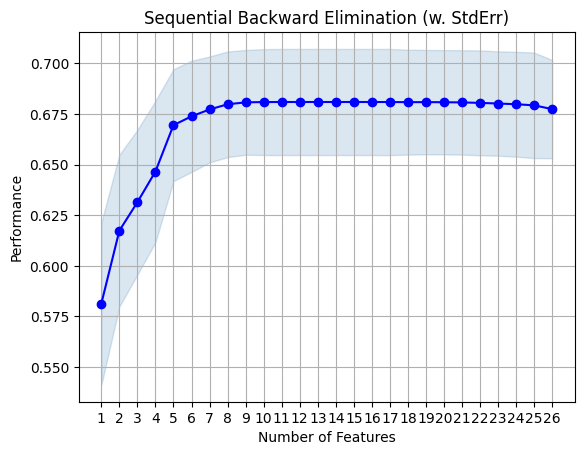

In [201]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs = SFS(lr, k_features='best', forward=True, floating=False, scoring='r2', cv=5)

sfs.fit(X, y)

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_err',)
plt.title('Sequential Backward Elimination (w. StdErr)')
plt.grid()
plt.show()

In [202]:
metric_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
metric_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(19,)","[0.558946903870017, 0.5294566869970747, 0.7006...",0.58,"(Value at beginning of 2022/23 season,)",0.10,0.08,0.04
2,"(19, 21)","[0.5778351404491083, 0.5695392027889179, 0.729...",0.62,"(Value at beginning of 2022/23 season, AgeBucket)",0.10,0.07,0.04
3,"(17, 19, 21)","[0.6138035100790362, 0.570904548707192, 0.7497...",0.63,"(Value at beginning of 2020/21 season, Value a...",0.09,0.07,0.04
4,"(17, 19, 21, 25)","[0.6118504480195385, 0.595970473499725, 0.7640...",0.65,"(Value at beginning of 2020/21 season, Value a...",0.09,0.07,0.03
5,"(3, 17, 19, 21, 25)","[0.6477911682877195, 0.6294838050316393, 0.756...",0.67,"(Attempted Passes, Value at beginning of 2020/...",0.07,0.06,0.03
6,"(3, 17, 19, 21, 22, 25)","[0.6557254991967603, 0.6270497810290431, 0.759...",0.67,"(Attempted Passes, Value at beginning of 2020/...",0.07,0.05,0.03
7,"(3, 15, 17, 19, 21, 22, 25)","[0.6519419421974524, 0.6418765899338388, 0.768...",0.68,"(Attempted Passes, Touches in attacking penalt...",0.07,0.05,0.03
8,"(3, 10, 15, 17, 19, 21, 22, 25)","[0.650403550369887, 0.6452119498958555, 0.7698...",0.68,"(Attempted Passes, Progressive Passes Rec, Tou...",0.07,0.05,0.03
9,"(0, 3, 10, 15, 17, 19, 21, 22, 25)","[0.6511270785546573, 0.6461639976810136, 0.769...",0.68,"(Aerial Duels won, Attempted Passes, Progressi...",0.07,0.05,0.03
10,"(0, 3, 10, 12, 15, 17, 19, 21, 22, 25)","[0.6493633220575057, 0.6450799984056503, 0.770...",0.68,"(Aerial Duels won, Attempted Passes, Progressi...",0.07,0.05,0.03


In [203]:
import pandas as pd
# This says, most important features are: Aerial Duels won, Attempted Passes, Progressive Passes Rec, Touches in attacking penalty area, 
# Value at beginning of 2020/21 season, Value at beginning of 2022/23 season, AgeBucket, PassCompletionBucket, Total Offensive Contributions
pd.set_option("display.max_columns", None)
X.head(3)

,Aerial Duels won,Assists,Attacking options created,Attempted Passes,Blocks,Clearances,Expected Goal Contributions,Interceptions,Open Play Goals,Open Play Expected Goals,Progressive Passes Rec,Progressive Passes,Progressive Carries,Shots,Successful Dribbles,Touches in attacking penalty area,Tackles,Value at beginning of 2020/21 season,Value at beginning of 2021/22 season,Value at beginning of 2022/23 season,Progressive Passes per Attempted Passes,AgeBucket,PassCompletionBucket,Defensive Reliability,Attacking Prowess,Total Offensive Contributions
0,1.30,0.11,3.68,31.80,0.69,0.97,0.16,1.10,0.06,0.20,8.60,4.24,2.81,2.41,1.61,4.36,1.89,0.20,0.80,1.30,0.13,2.00,3.00,2.76,6.20,0.17
1,0.20,0.17,3.49,29.50,0.52,0.00,0.25,0.20,0.00,0.16,8.21,3.32,6.47,1.75,1.40,6.82,0.87,0.40,10.78,1.00,0.11,1.00,3.00,0.72,5.41,0.17
2,0.00,0.28,2.99,27.50,0.76,0.36,0.26,0.20,0.12,0.20,6.95,2.45,3.62,1.41,0.88,3.98,0.72,7.50,2.50,1.80,0.09,2.00,2.00,1.32,4.68,0.40


In [204]:
# Testing
columns_to_drop = [
    "Value at beginning of 2023/24 season",
    "Progressive Passes per Attempted Passes",
    "Assists",
    "Open Play Expected Goals",
    "Expected Goal Contributions",
    "Attacking Prowess",
    "Successful Dribbles",
    'Clearances',
    'Attacking options created',
    "Blocks",
    "Shots",
    "id", "Name", "Country"
]

# Select the columns you want to keep
columns_to_keep = [col for col in df.columns if col not in columns_to_drop]

# Create a new DataFrame X with the selected columns
X = df.select(columns_to_keep).toPandas()

y = df.select('Value at beginning of 2023/24 season').toPandas()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

import lazypredict
from lazypredict.Supervised import LazyRegressor

regressors = LazyRegressor(ignore_warnings=True, custom_metric=None)
models, predictions = regressors.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 42/42 [00:04<00:00, 10.19it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HuberRegressor                               0.49       0.52  9.33        0.04
ElasticNet                                   0.49       0.52  9.34        0.01
LinearSVR                                    0.49       0.52  9.37        0.02
Lasso                                        0.48       0.51  9.44        0.01
LassoLars                                    0.48       0.51  9.44        0.01
TweedieRegressor                             0.48       0.51  9.44        0.01
SGDRegressor                                 0.47       0.50  9.53        0.01
ElasticNetCV                                 0.47       0.50  9.54        0.04
RandomForestRegressor                        0.46       0.49  9.62        0.86
BayesianRidge                                0.46       0.49  9.62        0.02
LassoCV                                      0.46   

In [205]:
string_indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex")
encoder = OneHotEncoder(inputCol="CountryIndex", outputCol="CountryVector")
pipeline = Pipeline(stages=[string_indexer, encoder])

# Fit and transform the DataFrame using the Pipeline
pipe = pipeline.fit(df)
df = pipe.transform(df)

# Show the DataFrame with one-hot encoding
df = df.drop("id", "Name", "Country", "CountryIndex")
df.show()

+----------------+-------+-------------------------+----------------+------+----------+---------------------------+-------------+---------------+------------------------+----------------------+------------------+-------------------+-----+-------------------+---------------------------------+-------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+---------------------------------------+---------+--------------------+---------------------+-----------------+-----------------------------+---------------+
|Aerial Duels won|Assists|Attacking options created|Attempted Passes|Blocks|Clearances|Expected Goal Contributions|Interceptions|Open Play Goals|Open Play Expected Goals|Progressive Passes Rec|Progressive Passes|Progressive Carries|Shots|Successful Dribbles|Touches in attacking penalty area|Tackles|Value at beginning of 2020/21 season|Value at beginning of 2021/22 season|Value at beginning o

# **ML Model**

In [206]:
# Assemble features including 'CountryVector'
feature_cols = df.drop("Value at beginning of 2023/24 season", "Progressive Passes per Attempted Passes", "Assists", "Open Play Expected Goals",
"Expected Goal Contributions", "Attacking Prowess", "Successful Dribbles", 'Clearances', 'Attacking options created', "Blocks", "Shots").columns

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
output = assembler.transform(df)

data = output.select("features", "Value at beginning of 2023/24 season")

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.9, 0.1], seed=123)

# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Value at beginning of 2023/24 season", standardization=False)

# Define a parameter grid for hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.0, 0.01, 0.08, 0.1, 0.2, 0.5, 0.8, 1.0])  # Regularization parameter
              .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.5, 0.8, 1.0])  # Elastic Net mixing parameter
              .build())

# Create a CrossValidator for hyperparameter tuning
cross_val = CrossValidator(estimator=lr,
                           estimatorParamMaps=param_grid,
                           evaluator=RegressionEvaluator(labelCol="Value at beginning of 2023/24 season", metricName="rmse"),
                           numFolds=10)  # Number of cross-validation folds

# Fit the CrossValidator to the training data
best_model = cross_val.fit(train_data).bestModel

# Make predictions on the test data
predictions = best_model.transform(test_data)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="Value at beginning of 2023/24 season", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 9.819649944557606


In [207]:
# Access the best parameters from the best model
best_reg_param = best_model._java_obj.getRegParam()
best_elastic_net_param = best_model._java_obj.getElasticNetParam()

print(f"Best Regularization Parameter (regParam): {best_reg_param}")
print(f"Best Elastic Net Parameter (elasticNetParam): {best_elastic_net_param}")

Best Regularization Parameter (regParam): 0.1
Best Elastic Net Parameter (elasticNetParam): 0.5


# **Predictions**

In [208]:
test_df = spark.read.csv('test.csv', header=True, inferSchema=True)

# Calculate 'Progressive Passes per Attempted Passes'
test_df = test_df.withColumn("Progressive Passes per Attempted Passes", col("Progressive Passes") / col("Attempted Passes"))

# Fill missing values in 'Country' with 'Other'
test_df = test_df.fillna("Other", subset=["Country"])

test_df = test_df.withColumn("Country", when(~col("Country").isin(unique_countries), "Other").otherwise(col("Country")))

# Reshape 'Age' and 'Percentage of Passes Completed' columns
test_df = age_bucketizer.transform(test_df)
test_df = pass_completion_bucketizer.transform(test_df)

test_df = test_df.drop(*['Age', 'Percentage of Passes Completed'])

# Apply the same mean imputation to the test data
test_df = test_df.join(mean_values, on="Country", how="left")

test_df = test_df.withColumn("Value at beginning of 2020/21 season", when(col("Value at beginning of 2020/21 season").isNull(), col("mean_2020_21")).otherwise(col("Value at beginning of 2020/21 season")))

test_df = test_df.withColumn("Value at beginning of 2021/22 season", when(col("Value at beginning of 2021/22 season").isNull(), col("mean_2021_22")).otherwise(col("Value at beginning of 2021/22 season")))

test_df = test_df.withColumn("Value at beginning of 2022/23 season", when(col("Value at beginning of 2022/23 season").isNull(), col("mean_2022_23")).otherwise(col("Value at beginning of 2022/23 season")))

test_df = test_df.drop("mean_2020_21", "mean_2021_22", "mean_2022_23")

In [209]:
# Calculate 'Defensive Reliability'
test_df = test_df.withColumn("Defensive Reliability", col("Interceptions") + col("Blocks") + col("Clearances"))

# Calculate 'Attacking Prowess'
test_df = test_df.withColumn("Attacking Prowess", col("Assists") + col("Attacking options created") + col("Shots"))

# Calculate 'Total Offensive Contributions'
test_df = test_df.withColumn("Total Offensive Contributions", col("Assists") + col("Open Play Goals"))

# Assuming you have already defined the 'Country' string indexer and encoder, apply the same transformations
test_df = pipe.transform(test_df)
test_df.show()

+--------+----+----------------+-------+-------------------------+----------------+------+----------+---------------------------+-------------+---------------+------------------------+----------------------+------------------+-------------------+-----+-------------------+---------------------------------+-------+------------------------------------+------------------------------------+------------------------------------+---------------------------------------+---------+--------------------+---------------------+-------------------+-----------------------------+------------+---------------+
| Country|  id|Aerial Duels won|Assists|Attacking options created|Attempted Passes|Blocks|Clearances|Expected Goal Contributions|Interceptions|Open Play Goals|Open Play Expected Goals|Progressive Passes Rec|Progressive Passes|Progressive Carries|Shots|Successful Dribbles|Touches in attacking penalty area|Tackles|Value at beginning of 2020/21 season|Value at beginning of 2021/22 season|Value at begin

In [210]:
test_df.dtypes

[('Country', 'string'),
 ('id', 'int'),
 ('Aerial Duels won', 'double'),
 ('Assists', 'double'),
 ('Attacking options created', 'double'),
 ('Attempted Passes', 'double'),
 ('Blocks', 'double'),
 ('Clearances', 'double'),
 ('Expected Goal Contributions', 'double'),
 ('Interceptions', 'double'),
 ('Open Play Goals', 'double'),
 ('Open Play Expected Goals', 'double'),
 ('Progressive Passes Rec', 'double'),
 ('Progressive Passes', 'double'),
 ('Progressive Carries', 'double'),
 ('Shots', 'double'),
 ('Successful Dribbles', 'double'),
 ('Touches in attacking penalty area', 'double'),
 ('Tackles', 'double'),
 ('Value at beginning of 2020/21 season', 'double'),
 ('Value at beginning of 2021/22 season', 'double'),
 ('Value at beginning of 2022/23 season', 'double'),
 ('Progressive Passes per Attempted Passes', 'double'),
 ('AgeBucket', 'double'),
 ('PassCompletionBucket', 'double'),
 ('Defensive Reliability', 'double'),
 ('Attacking Prowess', 'double'),
 ('Total Offensive Contributions', 'dou

In [211]:
# List of columns with string values to be converted to numeric
string_columns = [
    "Value at beginning of 2020/21 season",
    "Value at beginning of 2021/22 season",
    "Value at beginning of 2022/23 season",
    "Progressive Passes per Attempted Passes",
    "Defensive Reliability",
    "Attacking Prowess",
    "Total Offensive Contributions"
]

# Convert each string column to double type
for column in string_columns:
    test_df = test_df.withColumn(column, col(column).cast("double"))

In [212]:
# Show the DataFrame with one-hot encoding
X = test_df.drop("id", "Country", "CountryIndex", "Value at beginning of 2023/24 season", "Progressive Passes per Attempted Passes", "Assists", 
                "Open Play Expected Goals", "Expected Goal Contributions", "Attacking Prowess", "Successful Dribbles", 'Clearances', 
                'Attacking options created', "Blocks", "Shots")
X.show()

+----------------+----------------+-------------+---------------+----------------------+------------------+-------------------+---------------------------------+-------+------------------------------------+------------------------------------+------------------------------------+---------+--------------------+---------------------+-----------------------------+---------------+
|Aerial Duels won|Attempted Passes|Interceptions|Open Play Goals|Progressive Passes Rec|Progressive Passes|Progressive Carries|Touches in attacking penalty area|Tackles|Value at beginning of 2020/21 season|Value at beginning of 2021/22 season|Value at beginning of 2022/23 season|AgeBucket|PassCompletionBucket|Defensive Reliability|Total Offensive Contributions|  CountryVector|
+----------------+----------------+-------------+---------------+----------------------+------------------+-------------------+---------------------------------+-------+------------------------------------+----------------------------------

In [213]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
test_data = assembler.transform(X)

predictions = best_model.transform(test_data)

df_1 = test_df.toPandas()
df_2 = predictions.toPandas()

submission = pd.DataFrame(columns=['id', 'label'])
submission['id'] = df_1['id']
submission['label'] = df_2['prediction']

submission.to_csv('submission.csv', index=False)

In [214]:
#End Session
spark.stop()